In [15]:
import os
os.chdir('..')

In [24]:
from pprint import pprint
import rdkit
from rdkit import Chem
from torch_geometric.data import Data
import tqdm

from src.utils import *

In [18]:
all_candidates_train = load_pkl('cache/pkl/v1/candidates.test.pkl')
all_candidates_test = load_pkl('cache/pkl/v1/candidates.train.pkl')

In [22]:
def mapped_smiles_reader(file_path):
    f = open(file_path, 'r')
    all_drugs = f.read().split('\n')[:-1]
    all_drugs = [x.split('|') for x in all_drugs]
    return all_drugs

mapped_smiles = mapped_smiles_reader('cache/mapped_drugs/all_mapped.txt')

def find_drug_smiles(mapped_smiles, drug_name):
    drug_name = drug_name.lower()
    for smiles in mapped_smiles:
        if drug_name == smiles[1]:
            return smiles[2]
    return 'None'

def candidate_smiles(all_candidates, mapped_smiles):
    x = list()
    y = list()
    for candidate in tqdm(all_candidates):
        e1 = candidate['e1']['@text']
        e2 = candidate['e2']['@text']
        smiles1 = find_drug_smiles(mapped_smiles, e1)
        smiles2 = find_drug_smiles(mapped_smiles, e2)
        if smiles1 != 'None' and smiles2 != 'None':
            label = candidate['label']
            x.append([smiles1, smiles2])
            y.append(label)
    
    return x, y

In [23]:
x_train, y_train = candidate_smiles(all_candidates_train, mapped_smiles)
x_test, y_test = candidate_smiles(all_candidates_test, mapped_smiles)

100%|██████████| 27792/27792 [00:03<00:00, 8345.38it/s]


In [24]:
from torch_geometric import transforms
ohd = transforms.OneHotDegree(max_degree=4)

In [91]:
mol = Chem.MolFromSmiles(smiles) # Read the molecule info
adj = Chem.GetAdjacencyMatrix(mol) # Get molecule structure
# You should extract other features here!
data = Data(num_nodes=adj.shape[0], edge_index=torch.Tensor(adj).nonzero().T)

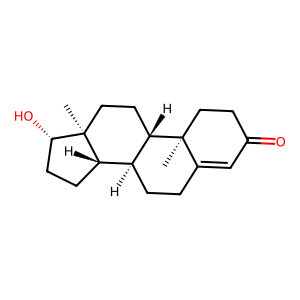

In [92]:
from rdkit.Chem import Draw
img = Draw.MolToImage(mol)
img

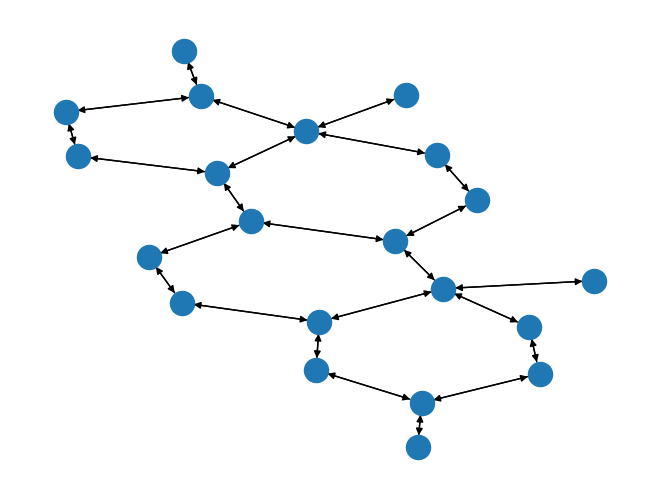

In [93]:
from torch_geometric import utils
import networkx as nx

G = utils.to_networkx(data)
nx.draw_kamada_kawai(G)

In [40]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

MANUAL_SEED = 41


class GCN(torch.nn.Module):
    def __init__(self, num_node_features=64, hidden_channels=64, num_classes=5):
        super(GCN, self).__init__()
        torch.manual_seed(MANUAL_SEED)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
)


In [41]:
data.x

In [42]:
GCN(data.x, data.edge_index)

TypeError: '>' not supported between instances of 'NoneType' and 'int'